# Analysis of tweets about Ukraine using text mining techniques

"Data is the new oil" - it is only one of many thoughts about data which shows a high value of information. Nowadays we collect many data, much more than in the past and also we have more sources of this data. This project is aimed on collecting, preparing and analysing posts from one of the most popular social networking service - Twitter. Using Twitter's REST API, tweets with query "Ukraine" are collected, then cleaned and analyzed data is used in topic modelling using LDA. In the second project "NER and Sentiment analysis with tweets about Ukraine" the same data is used in Named Entity Recognition and Sentiment analysis.


Note: "Data collection" part is presented just for reader to know how the data was collected. In order to execute this code, the reader needs to configure his own keys. However, the project works without executing "Data collection" part.

In [1]:
from datetime import date, timedelta
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
import tweepy
from tweepy import OAuthHandler
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 
import re
import warnings
warnings.filterwarnings("ignore")

## Data collection

Data are collected using Twitter's REST API. Tweets in english about Ukraine, from 2022-01-27 to 2022-02-04 are selected. To use mentioned API, developer has to know four private keys - "consumer key", "consumer secret", "access token" and "access token secret" - which are available after creating account on Twitter's API website. Code below show how connection with API is achieved and how the data is downloaded. More information upon the link: https://developer.twitter.com/en/docs/twitter-api

## Data analysis

Awareness of data is one of the most important steps for properness in decision making. In this part the data is analysed in order to make properly decisions in further steps.

In [2]:
df_U = pd.read_csv("df_Ukraine.csv")
df_U=df_U.rename(columns={"Tweets": "tweet"})
df_U

,tweet
0,RT @kennardmatt: The Azov Battalion was a neo-...
1,RT @john_sipher: “A free Ukraine will pull Rus...
2,RT @Reuters: President Joe Biden said that he ...
3,RT @DCBMEP: .@BorisJohnson on top form at #PMQ...
4,RT @DonaldJTrumpJr: Americas kids dying in a E...
...,...
763,All my hope goes to the brave NATO troops curr...
764,Russia Planned Fake Video to Gain Support for ...
765,I'm going to say it again you can hold a neutr...
766,RT @TimothyDSnyder: 0/6. A thread: Six Things ...


In [3]:
len(df_U)

768

In [4]:
df_U['tweet'].nunique()

619

In [5]:
df_U[df_U.duplicated(subset=['tweet'])==True]

,tweet
9,RT @BestForBritain: That’s strange. The PM tol...
16,RT @BestForBritain: That’s strange. The PM tol...
32,RT @LeftFlankVets: United States got weapons t...
34,RT @Ladyinyellow__: How did my healthy brother...
41,RT @LeftFlankVets: United States got weapons t...
...,...
736,"RT @RepAdamSchiff: First, Cruz begs forgivenes..."
749,RT @27khv: What @anneapplebaum doesn’t reveal ...
753,RT @27khv: What @anneapplebaum doesn’t reveal ...
760,RT @OlgaNYC1211: Just an observation. If you c...


In [6]:
df_U['is_retweet'] = df_U['tweet'].apply(lambda x: x[:2]=='RT')
df_U['is_retweet'].sum()  # number of retweets

588

In [7]:
df_U.loc[df_U['is_retweet']].tweet.nunique()

439

In [8]:
# 10 most repeated tweets
pd.options.display.max_colwidth = 200
df_U.groupby(['tweet']).size().reset_index(name='counts')\
  .sort_values('counts', ascending=False).head(10)

,tweet,counts
523,RT @ryangrim: Biden is in the process of starving and freezing to death millions of people in Afghanistan and there’s war fever over Ukrain…,12
234,"RT @JackPosobiec: Apparently, Biden was unaware of the talks going on this week in Paris between Germany, France, Russia, and Ukraine",10
532,RT @spaceeong: drop chief keef on the russia ukraine border shit would be handled in a few hours,9
546,"RT @thevivafrei: Coward @JustinTrudeau in hiding, worrying about Ukraine’s “territorial integrity” while simultaneously violating Canadians…",7
473,RT @leonidragozin: Ukraine is directly accusing the US of spreading disinfo,7
261,"RT @Ladyinyellow__: How did my healthy brother die in Ukraine overnight?\n\nA thread.\n\nThat's my brother, Fadlullah Agboluaje in this picture…",6
436,RT @emilyhorne46: This is not true. President Biden said that there is a distinct possibility that the Russians could invade Ukraine in Feb…,6
337,RT @RonnyJacksonTX: Something IS NOT right with the Biden Administration’s approach to Ukraine. It’s totally illogical. It makes ZERO sense…,5
307,RT @RWPUSA: Constitutional law 101: Is withholding military aid for Ukraine in order to coerce a criminal investigation of a political oppo…,4
474,"RT @levparnas: Hey @DonaldJTrumpJr, I taught you and your daddy where Ukraine is on a map. This crisis is due to his corrupt quid pro quo t…",4


Dataset with tweets collected using Twitter's REST API is loaded. It contains 768 tweets about Ukraine, where 619 are unique tweets. Number of downloaded tweets is limited by API's setting, which does not allow to download more than 100 tweets in one iteration. In probe 588 are retweets and 439 are unique retweets. In the table are visible 10 most repeated tweets.

In [9]:
def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet) 

In [10]:
df_U['retweeted'] = df_U.tweet.apply(find_retweeted)
df_U['mentioned'] = df_U.tweet.apply(find_mentioned)
df_U['hashtags'] = df_U.tweet.apply(find_hashtags)

In [11]:
pd.set_option('display.min_rows', 20)
df_U

,tweet,is_retweet,retweeted,mentioned,hashtags
0,"RT @kennardmatt: The Azov Battalion was a neo-Nazi paramilitary unit made up of football hooligans. Soon after the ""Maidan revolution"" in 2…",True,[@kennardmatt],[],[]
1,RT @john_sipher: “A free Ukraine will pull Russia westward if it isn’t brought to heel.” https://t.co/NjGViJWzHc,True,[@john_sipher],[],[]
2,RT @Reuters: President Joe Biden said that he would consider imposing direct sanctions on President Vladimir Putin if Russia invades Ukrain…,True,[@Reuters],[],[]
3,RT @DCBMEP: .@BorisJohnson on top form at #PMQs - Labour look sunken behind Starmer; who has missed his target: ‘a lawyer not a Leader’. No…,True,[@DCBMEP],[@BorisJohnson],[#PMQs]
4,RT @DonaldJTrumpJr: Americas kids dying in a European land war with Russia is a small price to pay for Hunter Biden and fam to get rich AF…,True,[@DonaldJTrumpJr],[],[]
5,"RT @WriterJackWhite: As @nato meets Russia under Putin's blackmail of 100,000 troops to invade Ukraine. In 2018 after NATO meet after Salis…",True,[@WriterJackWhite],[@nato],[]
6,"RT @JuliaDavisNews: The tactic of terrorizing American audiences with the possibility of nuclear war, in order to undermine U.S. support fo…",True,[@JuliaDavisNews],[],[]
7,RT @BestForBritain: That’s strange. The PM told Parliament he is the one leading Europe on Ukraine negotiations. He’s not even in the room.…,True,[@BestForBritain],[],[]
8,@davnrussell @ASBMilitary All this could be resolved if Ukraine remains neutral it’s really simple. No need for a N… https://t.co/nTRWngCO11,False,[],"[@davnrussell, @ASBMilitary]",[]
9,RT @BestForBritain: That’s strange. The PM told Parliament he is the one leading Europe on Ukraine negotiations. He’s not even in the room.…,True,[@BestForBritain],[],[]


In [12]:
# popular hashtags
hashtags_list_df = df_U.loc[df_U.hashtags.apply(lambda hashtags_list: hashtags_list !=[]),['hashtags']]

flattened_hashtags_df = pd.DataFrame(
[hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])

popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
popular_hashtags.head(10)

,hashtag,counts
0,#Ukraine,25
1,#Russia,11
2,#BREAKING,4
3,#NATO,4
4,#MeganRapinoe,4
5,#TigrayGenocide,2
6,#China,2
7,#UNCharter,2
8,#JohnsonTheCorru,2
9,#AffiliateMarketing,1


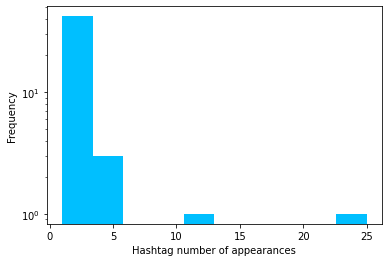

In [13]:
counts = flattened_hashtags_df.groupby(['hashtag']).size()\
                              .reset_index(name='counts')\
                              .counts

plt.figure()
plt.hist(counts,color='deepskyblue')
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('Hashtag number of appearances')
plt.ylabel('Frequency',)
plt.yscale('log', nonposy='clip')
plt.show()

Three definied function are used to get information about who is being retweeted, who is being tweeted at/mentioned and what hashtags are being used. #Ukraine is the most often used hashtag, what is not a surprise, because tweets about Ukraine were selected. Also second most often used hashtag #Russia has been expected. Other hashtags are used only in few tweets what is well visible on the hashtag frequency plot. 

In [14]:
# take hashtags which appear at least this amount of times
min_appearance = 4
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[popular_hashtags.counts>=min_appearance]['hashtag'])


# make a new column with only the popular hashtags
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]


# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))
        
print(hashtag_vector_df)

                   popular_hashtags  #BREAKING  #MeganRapinoe  #Ukraine  \
37                        [#Russia]          0              0         0   
50                       [#Ukraine]          0              0         1   
63             [#Ukraine, #Ukraine]          0              0         1   
103                      [#Ukraine]          0              0         1   
192                     [#BREAKING]          1              0         0   
202             [#Ukraine, #Russia]          0              0         1   
275                       [#Russia]          0              0         0   
326                      [#Ukraine]          0              0         1   
327               [#NATO, #Ukraine]          0              0         1   
330             [#Russia, #Ukraine]          0              0         1   
345               [#NATO, #Ukraine]          0              0         1   
348                       [#Russia]          0              0         0   
351                     [

In [15]:
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)
# calculate the correlation matrix
correlations = hashtag_matrix.corr()
print(correlations)

               #BREAKING  #MeganRapinoe  #Ukraine   #Russia     #NATO
#BREAKING       1.000000      -0.091287 -0.528004 -0.252523 -0.133333
#MeganRapinoe  -0.091287       1.000000 -0.361499 -0.172891 -0.091287
#Ukraine       -0.528004      -0.361499  1.000000  0.075099 -0.137740
#Russia        -0.252523      -0.172891  0.075099  1.000000 -0.252523
#NATO          -0.133333      -0.091287 -0.137740 -0.252523  1.000000


The hashtags with at least 4 appearances are considered as popular hashtags. The table above shows correlation between these hashtags. The highest correlation value is between #Ukraine and #Breaking which is reasonable taking into account the current situation.

## Text preprocessing

Tweets are not prepared for modelling. Therefore, implementing text preprocessing techniques is needed to achieve clean tweets which may be used in topic modelling.

In [16]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) 
    tweet = re.sub(r'bit.ly/\S+', '', tweet) 
    tweet = tweet.strip('[link]')
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)
    return tweet

In [17]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•“”’…@#'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() 
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) 
    tweet = re.sub('\s+', ' ', tweet) 
    tweet = re.sub('([0-9]+)', '', tweet) 
    tweet = re.sub('🔥🔥𝗕𝗥𝗘𝗔𝗞𝗜𝗡𝗚⎜|⚡️breaking⚡️','breaking',tweet)
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] 

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] 
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [18]:
df_U['clean_tweet'] = df_U.tweet.apply(clean_tweet)
df_U
#df_U.to_csv('df_U.csv', index=False, header=True) #saving dataset for second project

,tweet,is_retweet,retweeted,mentioned,hashtags,clean_tweet
0,"RT @kennardmatt: The Azov Battalion was a neo-Nazi paramilitary unit made up of football hooligans. Soon after the ""Maidan revolution"" in 2…",True,[@kennardmatt],[],[],azov battalion neo nazi paramilitari unit made footbal hooligan soon maidan revolut
1,RT @john_sipher: “A free Ukraine will pull Russia westward if it isn’t brought to heel.” https://t.co/NjGViJWzHc,True,[@john_sipher],[],[],free ukrain pull russia westward brought heel
2,RT @Reuters: President Joe Biden said that he would consider imposing direct sanctions on President Vladimir Putin if Russia invades Ukrain…,True,[@Reuters],[],[],presid joe biden said would consid impos direct sanction presid vladimir putin russia invad ukrain
3,RT @DCBMEP: .@BorisJohnson on top form at #PMQs - Labour look sunken behind Starmer; who has missed his target: ‘a lawyer not a Leader’. No…,True,[@DCBMEP],[@BorisJohnson],[#PMQs],top form pmq labour look sunken behind starmer miss target ‘a lawyer leader
4,RT @DonaldJTrumpJr: Americas kids dying in a European land war with Russia is a small price to pay for Hunter Biden and fam to get rich AF…,True,[@DonaldJTrumpJr],[],[],america kid die european land war russia small price pay hunter biden fam get rich af
5,"RT @WriterJackWhite: As @nato meets Russia under Putin's blackmail of 100,000 troops to invade Ukraine. In 2018 after NATO meet after Salis…",True,[@WriterJackWhite],[@nato],[],meet russia putin blackmail troop invad ukrain nato meet sali
6,"RT @JuliaDavisNews: The tactic of terrorizing American audiences with the possibility of nuclear war, in order to undermine U.S. support fo…",True,[@JuliaDavisNews],[],[],tactic terror american audienc possibl nuclear war order undermin u support fo
7,RT @BestForBritain: That’s strange. The PM told Parliament he is the one leading Europe on Ukraine negotiations. He’s not even in the room.…,True,[@BestForBritain],[],[],strang pm told parliament one lead europ ukrain negoti even room
8,@davnrussell @ASBMilitary All this could be resolved if Ukraine remains neutral it’s really simple. No need for a N… https://t.co/nTRWngCO11,False,[],"[@davnrussell, @ASBMilitary]",[],could resolv ukrain remain neutral realli simpl need n
9,RT @BestForBritain: That’s strange. The PM told Parliament he is the one leading Europe on Ukraine negotiations. He’s not even in the room.…,True,[@BestForBritain],[],[],strang pm told parliament one lead europ ukrain negoti even room


In order to achieve clean tweets are applied functions which are based on removing web links, retweet and @user information, lowering the text, striping punctuation, removing double spacing, stopwords, numbers and after it is applied word rooter. The results are visible in table above.

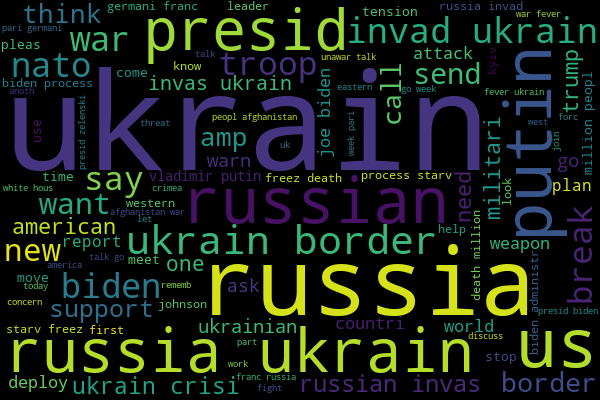

In [19]:
from wordcloud import WordCloud

#plt.figure(figsize=(10, 10)) 
long_string = ','.join(list(df_U['clean_tweet'].values))
wordcloud = WordCloud(background_color="black", max_words=100, contour_width=5,
                      contour_color='steelblue',width=600,height=400, min_word_length=2)
wordcloud.generate(long_string)
wordcloud.to_image()

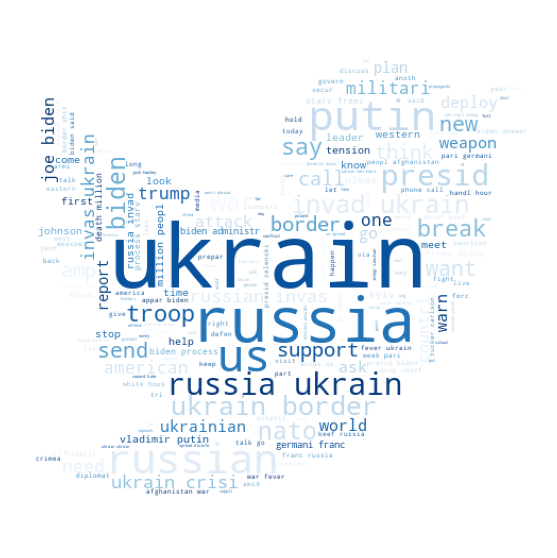

In [20]:
from imageio import imread

twitter_mask = imread('./twitter_mask.png')

wordcloud = WordCloud(
                    background_color='white',
                    width=800,
                    height=500,
                    mask=twitter_mask,
                    contour_color='deepskyblue',
                    min_word_length=2,colormap='Blues_r').generate(long_string)
plt.figure(figsize=(10, 10)) 
plt.imshow(wordcloud)
plt.axis("off")
#plt.savefig('./my_twitter_wordcloud.png', dpi=1000)
plt.show()

In order to visualize results, wordclouds are used. Wordclouds are visual representations of words that give greater prominence to words that appear more frequently. The most visible words on the plots above are "ukrain" and "russia".

## Topic modelling

Previous steps were necessary for applying topic modelling. Latent Dirichlet Allocation is used to indicate the hidden topics presented in the tweets.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=10, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(df_U['clean_tweet']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

tf_feature_names[:20]

['accus',
 'administr',
 'afghanistan',
 'also',
 'america',
 'american',
 'amid',
 'amp',
 'anoth',
 'appar',
 'approach',
 'ask',
 'attack',
 'biden',
 'border',
 'break',
 'britain',
 'call',
 'carlson',
 'chief']

In [22]:
from sklearn.decomposition import LatentDirichletAllocation

number_of_topics = 5
model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

model.fit(tf)

LatentDirichletAllocation(n_components=5, random_state=0)

In [23]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [24]:
no_top_words = 10
topics = display_topics(model, tf_feature_names, no_top_words)
topics

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,ukrain,96.8,ukrain,137.0,ukrain,76.2,ukrain,127.0,ukrain,157.0
1,biden,64.2,russia,56.5,russia,43.7,russian,74.9,russia,96.5
2,border,59.4,putin,27.8,go,31.9,invas,40.3,us,62.7
3,troop,44.9,support,23.2,germani,26.2,russia,35.0,presid,51.3
4,war,36.5,say,16.4,biden,24.7,putin,33.5,invad,34.1
5,send,35.9,ask,16.2,talk,22.9,militari,29.2,nato,31.1
6,peopl,34.2,ukrainian,16.2,border,20.0,plan,20.7,crisi,29.2
7,want,23.5,secur,15.9,would,19.9,need,20.2,war,28.8
8,million,21.2,new,14.0,europ,17.8,us,18.3,biden,26.0
9,joe,17.2,meet,13.2,week,15.2,amp,16.7,u,25.1


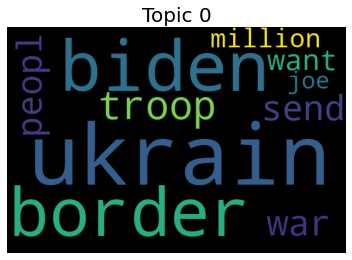

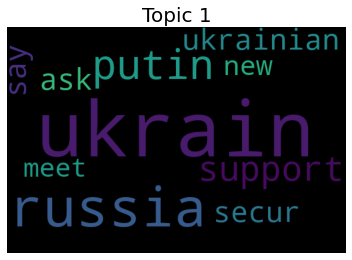

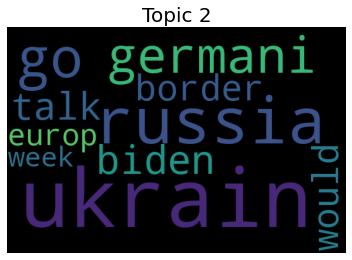

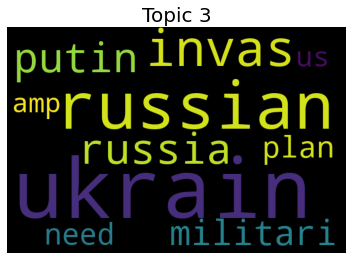

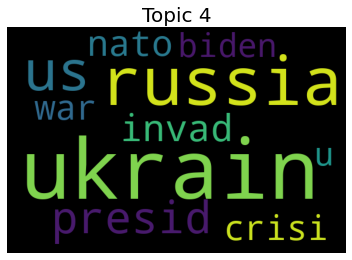

In [25]:
for i in range(0,len(topics.columns),2):
    topic_zip = dict(zip(topics.iloc[:,i],pd.to_numeric(topics.iloc[:,i+1])))
    wordcloud = WordCloud(width=600, height=400).fit_words(topic_zip)
    plt.figure( figsize=(5,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout()
    plt.title('Topic '+str(int(i/2)), size=20)
plt.show()

LDA with 5 topics and 10 words in topic is applied. Features for LDA are obtained using TF-IDF. Hidden topics achieved by LDA are shown not only in the table but also on the wordclouds. In every topic "ukrain" has the highest weight, but words like "russia" or "biden" are also really significant.

## Summary

The project is based on tweets between 2022-01-27 to 2022-02-04 about Ukraine collected by using Twitter's REST API. 768 tweets are analysed and prepared using appropriate text preprocessing techniques for further modelling. Cleaned tweets are used in topic modelling. By using TF-IDF and LDA 5 topics were obtained. 